In [3]:
import numpy as np
import matplotlib.pyplot as plt
import json
import time

np_generator = np.random.default_rng(69420)

#### Utility functions

In [4]:
def print_with_sums(array):
    for line in array:
        print(f"{line} ({np.sum(line)})")

def print_numbered(array, start = 1):
    for i in range(len(array)):
        print(f"{(i + start):2d}: {array[i]}")

def load_dataset(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return data

In [5]:
# A somewhat random initialization of assignments, taking into account reviewer capacity and minimum reviews required

def initialize_assignment(num_reviewers, num_papers, reviewer_capacity, min_reviews):
    
    # Initialize num_reviewers x num_papers array
    assignments = np.zeros((num_reviewers, num_papers), dtype=int)
    
    # Assign 'reviewer_capacity' papers to each reviewer, randomly
    for reviewer in range(num_reviewers):
        papers = np_generator.choice(num_papers, reviewer_capacity, replace=False)
        assignments[reviewer, papers] = 1

    # Add aditional reviewers to papers that do not have enough
    for paper in range(num_papers):
        current_reviews = assignments[:, paper].sum()
        if current_reviews < min_reviews:
            missing_reviews = min_reviews - current_reviews
            available_reviewers = np.nonzero(assignments[:, paper] == 0)[0]
            reviewers_to_add = np_generator.choice(available_reviewers, missing_reviews, replace=False)
            assignments[reviewers_to_add, paper] = 1

    return assignments

# A completely random initialization of assignments

def initialize_assignment_random(num_reviewers, num_papers):
    array = np_generator.rand(num_reviewers, num_papers)
    array[array >= 0.5] = 1
    array[array < 0.5] = 0
    array = array.astype(int)
    return array

# A greedy initialization where the most favorable papers are assigned

def initialize_assignment_greedy(num_reviewers, num_papers, preferences):
    array = np.zeros((num_reviewers, num_papers), dtype=int)
    array[preferences == 5] = 1
    array[preferences == 4] = 1
    array[preferences == 3] = 1
    return array

In [6]:
# Fitness function

# Count the number of overassigned reviewers (too many papers for one reviewer)
def count_overassigned_reviewers(assignments, reviewer_capacity):
    return np.sum(np.maximum(0, assignments.sum(axis=1) - reviewer_capacity))

# Count reviewers reviewing their own paper
def count_self_assignments(assignments, authorship):
    return np.sum(assignments * authorship > 0)    

# Count reviewers reviewing a friend's paper
def count_friend_assignments(assignments, friendships):
    counter = 0
    for reviewer in range(assignments.shape[0]):
        for paper in range(assignments.shape[1]):
            if assignments[reviewer, paper] == 1:
                counter += np.sum(assignments[:, paper] * friendships[reviewer, :] > 0)
    return counter
            
# Count papers with less than 'min_reviews' reviews
def count_underassigned_papers(assignments, min_reviews):
    return np.sum(np.maximum(0, min_reviews - assignments.sum(axis=0) ))

# Count papers with more than 'max_reviews' reviews
def count_overassigned_papers(assignments, max_reviews):
    return np.sum(np.maximum(0, assignments.sum(axis=0) - max_reviews))

# Calculate preference score
def preference_score(assignments, preferences):
    return np.sum(assignments * preferences)

# Calculate even-ness of the load distribution
def distribution_score(assignments):
    reviewer_load = np.sum(assignments, axis=1)
    paper_review_count = np.sum(assignments, axis=0)
    
    reviewer_balance_penalty = np.var(reviewer_load)
    paper_balance_penalty = np.var(paper_review_count)
    
    return reviewer_balance_penalty + paper_balance_penalty


def calculate_fitness_weighted(assignments, preferences, friendships, authorship, reviewer_capacity, min_reviews, max_reviews):
    
    weights = [
        100,    # Overassigned reviewers
        200,    # Self assignments
        100,     # Friend assignments
        50,     # Overassigned papers
        75,     # Underassigned papers
        15,     # Preference score
        1       # Distribution score
    ]

    score = 0
    score -= count_overassigned_reviewers(assignments, reviewer_capacity) * weights[0]
    score -= count_self_assignments(assignments, authorship) * weights[1]
    score -= count_friend_assignments(assignments, friendships) * weights[2]
    score -= count_underassigned_papers(assignments, min_reviews) * weights[4]
    score -= count_overassigned_papers(assignments, max_reviews) * weights[3]
    score += preference_score(assignments, preferences) * weights[5]
    # Turns out this isn't as helpful as first thought
    #score -= distribution_score(assignments) * weights[6]

    return score

In [7]:
# Check if paper assignment is valid

def is_valid_assignment(assignments, friendships, authorship, reviewer_capacity, min_reviews, max_reviews, izpisi = True):

    invalid_reasons = []
    is_valid = True

    # If any reviewer has too many assigned papers
    if count_overassigned_reviewers(assignments, reviewer_capacity):
        invalid_reasons.append("reviewer_capacity")
        is_valid = False
    
    # If any reviewer is reviewing their own paper
    if count_self_assignments(assignments, authorship):
        invalid_reasons.append("authorship")
        is_valid = False
    
    # If any reviewer is reviewing a friend's review
    if count_friend_assignments(assignments, friendships):
        invalid_reasons.append("friendships")
        is_valid = False
    
    # If any paper has more than 'max_reviews' reviews
    if count_overassigned_papers(assignments, max_reviews):
        invalid_reasons.append("max reviews")
        is_valid = False
    
    # If any paper has less than 'min_reviews' reviews
    if count_underassigned_papers(assignments, min_reviews):
        invalid_reasons.append("min reviews")
        is_valid = False
    
    if not is_valid and izpisi:
        print(f"Invalid reasons: {invalid_reasons}")
        
    return is_valid

In [8]:
# Mutation and crossover functions

def mutate(assignment, reviewer_capacity, min_reviews, max_reviews, friendships, authorship, mutation_rate=0.05):
    num_reviewers, num_papers = assignment.shape
    
    for i in range(int(mutation_rate * num_reviewers * num_papers)):
        reviewer = np.random.randint(num_reviewers)
        paper = np.random.randint(num_papers)
        
        if assignment[reviewer, paper] == 1:
            if assignment[reviewer].sum() > min_reviews:
                assignment[reviewer, paper] = 0
            else:
                i -= 1
        else:
            if (
                np.sum(assignment[reviewer]) < reviewer_capacity and
                authorship[reviewer, paper] == 0 and
                not np.any(assignment[:, paper] * friendships[reviewer, :]) and
                assignment[:, paper].sum() < max_reviews
            ):
                assignment[reviewer, paper] = 1
            else:
                i -= 1
    return assignment

def repair_assignment(assignment, reviewer_capacity, min_reviews, max_reviews, friendships, authorship):
    num_reviewers, num_papers = assignment.shape
    
    for reviewer in range(num_reviewers):
        for paper in range(num_papers):
            if assignment[reviewer, paper] == 1:
                if authorship[reviewer, paper] == 1:
                    assignment[reviewer, paper] = 0
                elif np.any(assignment[:, paper] * friendships[reviewer, :] > 0):
                    assignment[reviewer, paper] = 0

    for reviewer in range(num_reviewers):
        while np.sum(assignment[reviewer]) > reviewer_capacity:
            assigned_papers = np.where(assignment[reviewer] == 1)[0]
            paper_to_remove = np_generator.choice(assigned_papers)
            assignment[reviewer, paper_to_remove] = 0
    
    for paper in range(num_papers):
        while np.sum(assignment[:, paper]) < min_reviews:
            reviewers = np.where((assignment[:, paper] == 0) & 
                                (authorship[:, paper] == 0) & 
                                (np.all(friendships * assignment[:, paper] == 0, axis=1)) & 
                                (np.sum(assignment, axis=1) < reviewer_capacity)
                            )[0]
            if len(reviewers) == 0:
                break
            reviewer_to_add = np_generator.choice(reviewers)
            assignment[reviewer_to_add, paper] = 1
    
    return assignment

def single_point_crossover(parent1, parent2, reviewer_capacity, min_reviews, max_reviews, friendships, authorship):
    num_reviewers, _ = parent1.shape
    
    crossover_point = np.random.randint(1, num_reviewers)
    
    child = np.vstack((parent1[:crossover_point], parent2[crossover_point:]))
    
    child = repair_assignment(child, reviewer_capacity, min_reviews, max_reviews, friendships, authorship)
    return child

def two_point_crossover(parent1, parent2, reviewer_capacity, min_reviews, max_reviews, friendships, authorship):
    num_reviewers, _ = parent1.shape
    
    point1, point2 = np.sort(np_generator.choice(num_reviewers, 2, replace=False))
    
    child = np.vstack((parent1[:point1], parent2[point1:point2], parent1[point2:]))
    
    child = repair_assignment(child, reviewer_capacity, min_reviews, max_reviews, friendships, authorship)
    return child

def uniform_crossover(parent1, parent2, reviewer_capacity, min_reviews, max_reviews, friendships, authorship):
    num_reviewers, num_papers = parent1.shape
    
    child = np.zeros((num_reviewers, num_papers), dtype=int)
    
    for reviewer in range(num_reviewers):
        for paper in range(num_papers):
            if np_generator.random() < 0.5:
                child[reviewer, paper] = parent1[reviewer, paper]
            else:
                child[reviewer, paper] = parent2[reviewer, paper]
    
    child = repair_assignment(child, reviewer_capacity, min_reviews, max_reviews, friendships, authorship)
    return child

In [9]:
# Initialization and selection functions

def initialize_assignment_with_constraints(num_reviewers, num_papers, reviewer_capacity, friendships, authorship):
    assignments = np.zeros((num_reviewers, num_papers), dtype=int)
    
    # Brez vseh konfliktov (razen min in max število pregledov)
    for reviewer in range(num_reviewers):
        valid_papers = [
            paper for paper in range(num_papers)
            if authorship[reviewer, paper] == 0 and
               np.all(friendships[reviewer, :] * assignments[:, paper] == 0)
        ]
        
        if len(valid_papers) >= reviewer_capacity:
            papers_to_assign = np_generator.choice(valid_papers, reviewer_capacity, replace=False)
            assignments[reviewer, papers_to_assign] = 1
        else:
            assignments[reviewer, valid_papers] = 1

    return assignments

def initialize_population(num_reviewers, num_papers, reviewer_capacity, friendships, authorship, pop_size):
    population = []
    for _ in range(pop_size):
        assignment = initialize_assignment_with_constraints(num_reviewers, num_papers, reviewer_capacity, friendships, authorship)
        population.append(assignment)
    return population

def roulette_wheel_selection(population, fitnesses):
    total_fitness = sum(fitnesses)
    probabilities = [f / total_fitness for f in fitnesses]
    cumulative_probabilities = np.cumsum(probabilities)
    def select():
        r = np_generator.random()
        for i, prob in enumerate(cumulative_probabilities):
            if r < prob:
                return population[i]
    
    parent1 = select()
    parent2 = select()
    return parent1, parent2

def tournament_selection(population, fitnesses, k=5):
    def select():
        selected_indices = np_generator.choice(len(population), k, replace=False)
        best = max(selected_indices, key=lambda i: fitnesses[i])
        return population[best]
    
    parent1 = select()
    parent2 = select()
    return parent1, parent2

def rank_based_selection(population, fitnesses):
    sorted_indices = np.argsort(fitnesses)
    ranks = np.argsort(sorted_indices) + 1
    rank_probabilities = ranks / sum(ranks)
    cumulative_probabilities = np.cumsum(rank_probabilities)
    
    def select():
        r = np_generator.random()
        for i, prob in enumerate(cumulative_probabilities):
            if r < prob:
                return population[sorted_indices[i]]
    
    parent1 = select()
    parent2 = select()
    return parent1, parent2

In [10]:
# Genetic algorithm

def genetic_algorithm(preferences, friendships, authorship, reviewer_capacity, paper_reviews_needed, 
                      pop_size=20, generations=50, mutation_rate=0.1, elitism_rate = 0.1, izpisi = True,
                    crossover = single_point_crossover, selection = roulette_wheel_selection):
    num_reviewers, num_papers = preferences.shape
    min_reviews, max_reviews = paper_reviews_needed
    
    population = initialize_population(num_reviewers, num_papers, reviewer_capacity, friendships, authorship, pop_size)
    if izpisi:
        print("Initial gene")
        print(population[0])
        print("Fitness:", calculate_fitness_weighted(population[0], preferences, friendships, authorship, reviewer_capacity, paper_reviews_needed[0], paper_reviews_needed[1]))
        print("Valid:", is_valid_assignment(population[0], friendships, authorship, reviewer_capacity, paper_reviews_needed[0], paper_reviews_needed[1]))
    
    fitness_history = []
    elite_count = max(1, int(elitism_rate * pop_size))

    for gen in range(generations):
        fitnesses = [calculate_fitness_weighted(index, preferences, friendships, authorship, reviewer_capacity, min_reviews, max_reviews) for index in population]
        fitness_history.append(max(fitnesses))
        
        valids = [is_valid_assignment(index, friendships, authorship, reviewer_capacity, min_reviews, max_reviews, izpisi = False) for index in population]
        
        sorted_population = [x for _, _, x in sorted(zip(valids, fitnesses, population), key=lambda pair: (pair[0], pair[1]), reverse=True)]
        sorted_fitnesses = [x for _, x in sorted(zip(valids, fitnesses), key=lambda pair: (pair[0], pair[1]), reverse=True)]
        
        elites = sorted_population[:elite_count]

        next_population = elites[:]
        while len(next_population) < pop_size:
            parents = selection(sorted_population, sorted_fitnesses)
            child = crossover(parents[0], parents[1], reviewer_capacity, min_reviews, max_reviews, friendships, authorship)
            child = mutate(child, reviewer_capacity, min_reviews, max_reviews, friendships, authorship, mutation_rate=mutation_rate)
            next_population.append(child)
        
        population = next_population
    
    best_index = np.argmax(fitnesses)
    return population[best_index], max(fitnesses), fitness_history

In [11]:
dataset = load_dataset('datasets/medium_dataset_1.json')

# Preference, friendship authorship matrices and other data
preferences = np.array(dataset['preferences'])
friendships = np.array(dataset['friendships'])
authorship = np.array(dataset['authorship'])
num_papers = dataset['num_papers']
num_reviewers = dataset['num_reviewers']
reviewer_capacity = dataset['reviewer_capacity']
paper_review_constraints = (dataset['min_reviews_per_paper'], dataset['max_reviews_per_paper'])

# Print dataset data (helps with sanity checks)
print("Reviewer preferences in regards to paper:")
print_numbered(preferences)
print(f"Number of papers: {num_papers}")
print(f"Number of reviewers: {num_reviewers}")
print(f"Maximum papers per reviewer: {reviewer_capacity}")
print(f"Constraints on number of reviews (min/max) : {paper_review_constraints[0]}/{paper_review_constraints[1]}")
print("Authorship:")
print_numbered(authorship)
print("Friendships:")
print_numbered(friendships)

Reviewer preferences in regards to paper:
 1: [4 5 5 1 2 2 2 1 5 4]
 2: [2 5 5 5 1 3 2 4 5 4]
 3: [2 1 4 2 5 1 3 3 5 1]
 4: [2 4 3 1 5 2 3 2 1 1]
 5: [2 1 4 3 3 1 3 3 5 3]
 6: [0 2 4 2 3 3 5 5 5 4]
 7: [5 1 3 2 3 0 1 0 5 4]
Number of papers: 10
Number of reviewers: 7
Maximum papers per reviewer: 5
Constraints on number of reviews (min/max) : 3/5
Authorship:
 1: [0 0 0 0 0 0 0 0 0 1]
 2: [0 0 0 0 0 0 0 0 0 1]
 3: [0 0 0 1 0 0 0 0 0 0]
 4: [1 0 0 0 0 0 1 0 0 0]
 5: [0 0 0 0 0 0 0 0 0 0]
 6: [0 0 0 0 1 0 0 0 1 0]
 7: [0 1 1 0 0 1 0 1 0 0]
Friendships:
 1: [0 1 1 1 0 0 0]
 2: [1 0 0 0 1 0 0]
 3: [1 0 0 1 1 0 1]
 4: [1 0 1 0 0 0 0]
 5: [0 1 1 0 0 0 0]
 6: [0 0 0 0 0 0 0]
 7: [0 0 1 0 0 0 0]


Initial gene
[[1 1 0 1 0 1 0 1 0 0]
 [0 0 1 0 1 0 1 0 1 0]
 [0 0 1 0 1 0 1 0 1 1]
 [0 0 0 0 0 0 0 0 0 0]
 [1 1 0 1 0 1 0 1 0 0]
 [0 1 1 1 0 0 1 1 0 0]
 [1 0 0 1 0 0 0 0 0 0]]
Fitness: 810
Invalid reasons: ['min reviews']
Valid: False
Best solution:
[[1 0 0 0 0 0 1 0 1 0]
 [0 1 1 1 0 1 0 1 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 1 0 1 1 1 0 0 0 1]
 [1 0 0 0 1 0 1 0 1 1]
 [0 1 1 0 0 1 1 1 0 0]
 [1 0 0 1 1 0 0 0 1 1]]
Best fitness: 1605
Valid: True


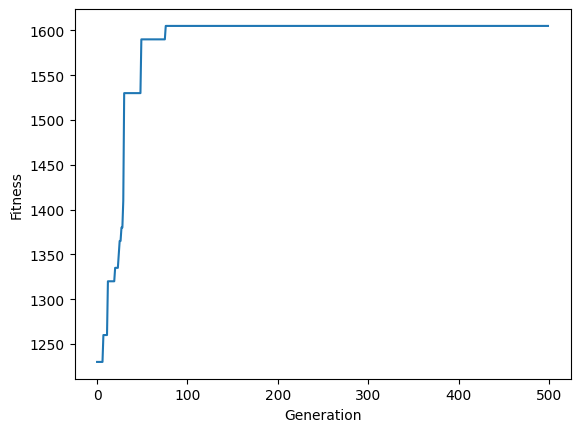

In [12]:
# Running the genetic algorithm

best_solution, best_fitness, fitness_history = genetic_algorithm(
    preferences, friendships, authorship, reviewer_capacity, paper_review_constraints,
    pop_size=20, generations=500, mutation_rate=0.1, elitism_rate=0.1
)

print("Best solution:")
print(best_solution)
print("Best fitness:", best_fitness)
print("Valid:",is_valid_assignment(best_solution, friendships, authorship, reviewer_capacity, paper_review_constraints[0], paper_review_constraints[1]))

plt.plot(fitness_history)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.show()

# Evaluation and Report

### Performance under different genetic algorithm configurations

#### a) Mutation rate: 
- The mutation rate was set to 0.10, with experimentation conducted across different mutation rates (0.01, 0.05, 0.10, 0.20, 0.30).
- Lower mutation rates (0.01, 0.05) resulted in slower convergence, and in most cases, the algorithm failed to converge to the optimal solution.
- Higher mutation rates (0.20, 0.30) led to faster convergence but, in some cases, the algorithm did not reach the optimal solution.
- The mutation rate around 0.10 resulted in the best performance of the algorithm.

#### b) Elitism rate:
- The elitism rate was set to 0.10, and various values (0, 0.05, 0.10, 0.20, 0.30) were tested.
- Lower elitism rates (0, 0.05) resulted in the best individuals not being preserved across generations, which slowed convergence and led to suboptimal solutions.
- Higher elitism rates (0.20, 0.30) resulted in the best individuals not being preserved across generations, which slowed convergence and led to suboptimal solutions.
- An elitism rate of 0.10 was found to be optimal, preserving the best individuals while maintaining sufficient diversity within the population.

#### c) Crossover method:
- We tested different crossover methods, including single-point, two-point, and uniform crossover.
- Both single-point and two-point crossover methods proved to be effective in generating diverse offspring with minimal disruption to existing solutions.

#### d) Selection method:
- Various selection methods were explored, including roulette wheel, tournament, and rank-based selection.
- Both roulette wheel and tournament selection performed particularly well, ensuring that the strongest individuals were selected, which contributed to faster convergence.

#### Results:
The best results were obtained with the following parameters:
    - mutation rate: 0.10
    - elitism rate: 0.10
    - crossover method: single-point or two-point
    - selection method: roulette wheel or tournament

This process of finding the best parameters was repeated for multiple datasets to ensure the robustness and versatility of the genetic algorithm.


### Robustness and Versatility:

- We evaluated the genetic algorithm on a variety of datasets, differing in size and complexity (e.g., number of papers, reviewers, and constraints).
- The algorithm consistently found valid assignments and optimized fitness scores across most datasets, though **easy_dataset_1** and **easy_dataset_2** did not allow for solutions satisfying all constraints. Despite this, the algorithm converged to the most optimal solution possible within the given constraints.
- The results highlight the robustness and versatility of the genetic algorithm, which is capable of handling different scenarios and constraints effectively.


### Algorithm Performance:

- The genetic algorithm demonstrated solid performance in terms of both convergence speed and solution quality.
- The algorithm scales well with dataset size, which is determined by the number of papers and the minimum number of reviews required for each paper.


## Conclusion:

In this study, we evaluated the performance of a genetic algorithm for assigning reviewers to papers, optimizing both the preference score and various constraints such as reviewer capacity, paper review requirements, friendships, and authorship. Through extensive experimentation, we explored the influence of key algorithm parameters, including mutation rate, elitism rate, crossover method, and selection strategy, on the algorithm's efficiency and solution quality.
- **Mutation rate** of 0.10 proved optimal, balancing convergence speed and solution quality.
- **Elitism rate** of 0.10 was found to be effective in preserving the best individuals while maintaining population diversity.
- **Crossover methods** such as single-point and two-point were effective in generating diverse offspring.
- **Selection strategies** like roulette wheel and tournament selection contributed to the algorithm's performance.

The genetic algorithm demonstrated robustness and versatility across varied datasets, effectively handling different constraints and scenarios. The algorithm's performance in terms of convergence speed and solution quality was satisfactory, showcasing its scalability with dataset size. Overall, the genetic algorithm proved to be a reliable and efficient approach for the reviewer assignment problem, offering a viable solution for optimizing the review process.

In conclusion, the genetic algorithm is a powerful tool for solving complex assignment problems. Its performance is heavily influenced by the choice of parameters, but it remains adaptable and effective across a wide range of problem sizes and constraints.


In [ ]:
# Finding the best parameters

mutation_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
elitism_rates = [0, 0.05, 0.1, 0.2, 0.3]
crossover_functions = [single_point_crossover, two_point_crossover, uniform_crossover]
selection_functions = [roulette_wheel_selection, tournament_selection, rank_based_selection]

results = []

for mutation_rate in mutation_rates:
    for elitism_rate in elitism_rates:
        for crossover_function in crossover_functions:
            for selection_function in selection_functions:
                best_solution, best_fitness, fitness_history = genetic_algorithm(
                    preferences, friendships, authorship, reviewer_capacity, paper_review_constraints,
                    pop_size=20, generations=200, mutation_rate=mutation_rate, elitism_rate=elitism_rate, izpisi = False, crossover = crossover_function, selection = selection_function
                )
                results.append((mutation_rate, elitism_rate, crossover_function.__name__, selection_function.__name__, best_fitness))
                print(f"Mutation rate: {mutation_rate}, Elitism rate: {elitism_rate}, Crossover: {crossover_function.__name__}, Selection: {selection_function.__name__}, Best fitness: {best_fitness}, is valid: {is_valid_assignment(best_solution, friendships, authorship, reviewer_capacity, paper_review_constraints[0], paper_review_constraints[1], izpisi = False)}")

results = sorted(results, key=lambda x: x[4], reverse=True)
print("Best results:")
print(results[:15])

Dataset: easy_dataset_1.json, Runtime: 3.31, Best fitness: 495, is valid: False
Dataset: easy_dataset_2.json, Runtime: 3.89, Best fitness: 630, is valid: False
Dataset: medium_dataset_1.json, Runtime: 6.1, Best fitness: 1590, is valid: True
Dataset: medium_dataset_2.json, Runtime: 7.6, Best fitness: 1800, is valid: True
Dataset: hard_dataset_1.json, Runtime: 9.97, Best fitness: 2250, is valid: True
Dataset: hard_dataset_2.json, Runtime: 14.9, Best fitness: 3450, is valid: True
Dataset: hard_dataset_3.json, Runtime: 18.85, Best fitness: 3720, is valid: True
Dataset: hard_dataset_4.json, Runtime: 24.23, Best fitness: 4530, is valid: True


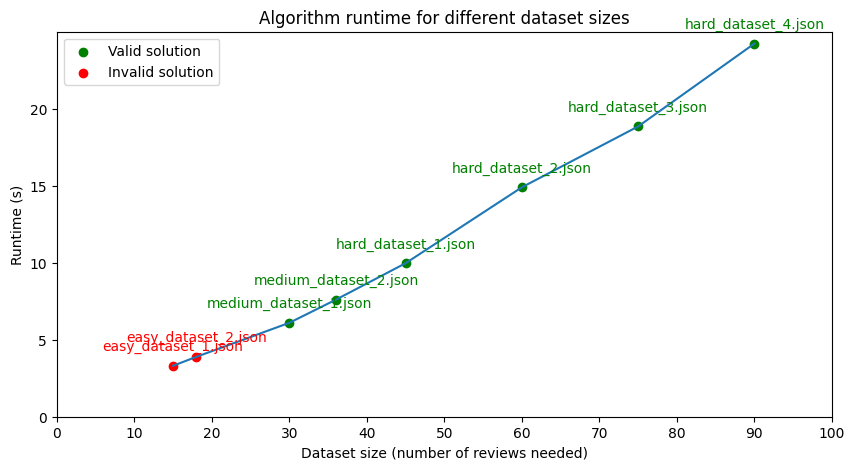

In [23]:
# Algorithm's runtimes for different dataset sizes

datasets = ['easy_dataset_1.json', 'easy_dataset_2.json', 'medium_dataset_1.json', 'medium_dataset_2.json', 'hard_dataset_1.json', 'hard_dataset_2.json', 'hard_dataset_3.json', 'hard_dataset_4.json']
runtimes = []
dataset_reviews_needed = []
dataset_result_validity = []

for dataset in datasets:
    data = load_dataset(f'datasets/{dataset}')
    preferences = np.array(data['preferences'])
    friendships = np.array(data['friendships'])
    authorship = np.array(data['authorship'])
    num_papers = data['num_papers']
    num_reviewers = data['num_reviewers']
    reviewer_capacity = data['reviewer_capacity']
    paper_review_constraints = (data['min_reviews_per_paper'], data['max_reviews_per_paper'])
    dataset_reviews_needed.append(paper_review_constraints[0] * num_papers)
    
    start_time = time.time()
    best_solution, best_fitness, fitness_history = genetic_algorithm(
        preferences, friendships, authorship, reviewer_capacity, paper_review_constraints,
        pop_size=20, generations=500, mutation_rate=0.1, elitism_rate=0.1, izpisi = False
    )
    end_time = time.time()
    runtime = round(end_time - start_time, 2)
    runtimes.append(runtime)

    valid = is_valid_assignment(best_solution, friendships, authorship, reviewer_capacity, paper_review_constraints[0], paper_review_constraints[1], izpisi = False)
    dataset_result_validity.append(valid)
    print(f"Dataset: {dataset}, Runtime: {runtime}, Best fitness: {best_fitness}, is valid: {valid}")


plt.figure(figsize=(10, 5))
plt.plot(dataset_reviews_needed, runtimes)
for i, name in enumerate(datasets):
    if dataset_result_validity[i]:
        plt.scatter(dataset_reviews_needed[i], runtimes[i], color='green')
        plt.text(dataset_reviews_needed[i], runtimes[i] + 1, name, ha='center', color='green')
    else:
        plt.scatter(dataset_reviews_needed[i], runtimes[i], color='red')
        plt.text(dataset_reviews_needed[i], runtimes[i] + 1, name, ha='center', color='red')

plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 10))

plt.ylim(0, np.ceil(np.max(runtimes)))
plt.yticks(np.arange(0, np.ceil(np.max(runtimes)), 5))

plt.ylabel("Runtime (s)")
plt.xlabel("Dataset size (number of reviews needed)")
plt.title("Algorithm runtime for different dataset sizes")

plt.scatter([], [], color='green', label='Valid solution')
plt.scatter([], [], color='red', label='Invalid solution')
plt.legend()

plt.show()